# REFRAG v1: Rethinking RAG-based Decoding - Explained

This notebook provides a comprehensive explanation of the REFRAG (REpresentation For RAG) implementation based on the paper "REFRAG: Rethinking RAG based Decoding" by Meta Superintelligence Labs.

## Table of Contents
1. [Introduction & Paper Overview](#1-introduction)
2. [The Problem with Standard RAG](#2-problem)
3. [REFRAG Architecture](#3-architecture)
4. [Core Components Deep Dive](#4-components)
5. [Training Pipeline](#5-training)
6. [Generation with REFRAG](#6-generation)
7. [Hands-on Examples](#7-examples)
8. [Summary & Key Takeaways](#8-summary)

## Setup and Dependencies

First, let's install and import all required dependencies.

In [ ]:
# Install dependencies if needed (uncomment if running for first time)
# !pip install torch transformers numpy faiss-cpu

In [1]:
import os
import sys
import json
import math
import time
import random
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup,
)

# Set random seeds for reproducibility
def seed_everything(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: mps


<a id='1-introduction'></a>
## 1. Introduction & Paper Overview

### What is REFRAG?

**REFRAG (REpresentation For RAG)** is a novel efficient decoding framework designed specifically for Retrieval-Augmented Generation (RAG) applications. It addresses the fundamental trade-off between knowledge enrichment and system efficiency in LLMs.

### Key Paper Claims

| Metric | Improvement |
|--------|-------------|
| TTFT (Time-To-First-Token) | **30.85x** acceleration |
| vs Previous SOTA (CEPE) | **3.75x** improvement |
| Context Extension | **16x** larger context |
| Perplexity Loss | **None** (maintains quality) |

### Core Insight from the Paper

> "In RAG, much of the LLM context consists of concatenated passages from retrieval, with only a small subset directly relevant to the query. These passages often exhibit low semantic similarity due to diversity or deduplication during re-ranking, leading to **block-diagonal attention patterns** that differ from standard LLM generation tasks."

This means most cross-attention between different retrieved passages is essentially zero - wasteful computation that REFRAG eliminates.

### Visual: Standard RAG vs REFRAG Pipeline

```
STANDARD RAG:
┌─────────────┐    ┌─────────────┐    ┌─────────────────────┐
│   Query     │───>│  Retriever  │───>│ [P1, P2, P3, ...Pk] │
└─────────────┘    └─────────────┘    └──────────┬──────────┘
                                                 │
                                                 v
                   ┌─────────────────────────────────────────┐
                   │     LLM Decoder (full token input)      │
                   │  [Query tokens] + [All passage tokens]  │
                   │     Attention: O(n²) complexity         │
                   └─────────────────────────────────────────┘

REFRAG:
┌─────────────┐    ┌─────────────┐    ┌─────────────────────┐
│   Query     │───>│  Retriever  │───>│ [P1, P2, P3, ...Pk] │
└─────────────┘    └─────────────┘    └──────────┬──────────┘
                                                 │
                                    ┌────────────┴────────────┐
                                    v                         v
                           ┌────────────────┐       ┌──────────────────┐
                           │ Light Encoder  │       │  RL Policy Net   │
                           │ (chunk→embed)  │       │ (select expand)  │
                           └───────┬────────┘       └────────┬─────────┘
                                   │                         │
                                   v                         v
                   ┌─────────────────────────────────────────────────┐
                   │              LLM Decoder                        │
                   │  [Query] + [Compressed chunks] + [Few expanded] │
                   │     Attention: O(L²) where L << n               │
                   └─────────────────────────────────────────────────┘
```

<a id='2-problem'></a>
## 2. The Problem with Standard RAG

### Why Standard RAG is Inefficient

Standard RAG has three key inefficiencies that REFRAG addresses:

#### 2.1 Inefficient Token Allocation
RAG contexts often contain sparse information with many retrieved passages being uninformative. Allocating memory/computation for all tokens is wasteful.

#### 2.2 Wasteful Encoding
The retrieval process has already pre-processed chunks and their encodings/correlations with the query are available from vectorization and re-ranking. This information is discarded during decoding.

#### 2.3 Unusually Structured and Sparse Attention
Due to diversity and deduplication, most context chunks are unrelated, resulting in predominantly zero cross-attention between chunks.

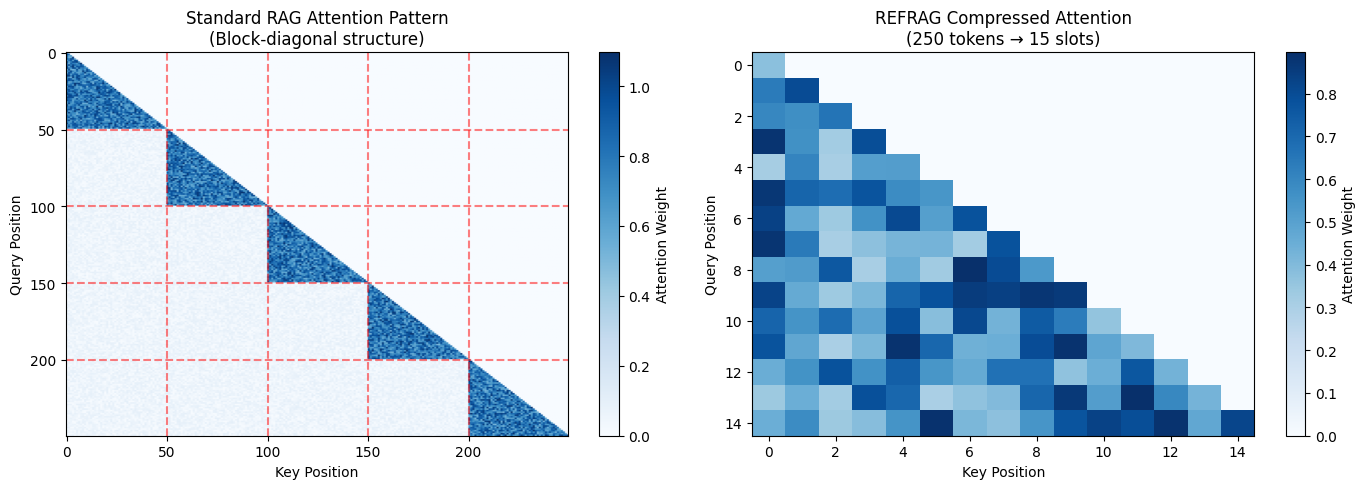


📊 Compression Analysis:
   Original tokens: 250
   Compressed slots: 15
   Attention operations: 62,500 → 225
   Compression ratio: 277.8x


In [2]:
# Let's visualize the attention sparsity problem
# In standard RAG with diverse passages, attention is mostly block-diagonal

import matplotlib.pyplot as plt

def visualize_rag_attention_pattern():
    """Simulate the block-diagonal attention pattern in RAG contexts."""
    # Simulate 5 passages, each with ~50 tokens
    n_passages = 5
    tokens_per_passage = 50
    total_tokens = n_passages * tokens_per_passage
    
    # Create block-diagonal attention matrix
    # High attention within passages, low between passages
    attention = np.zeros((total_tokens, total_tokens))
    
    for p in range(n_passages):
        start = p * tokens_per_passage
        end = (p + 1) * tokens_per_passage
        # Strong attention within passage
        attention[start:end, start:end] = np.random.uniform(0.5, 1.0, 
                                                             (tokens_per_passage, tokens_per_passage))
    
    # Add small random noise for cross-passage attention
    attention += np.random.uniform(0, 0.1, (total_tokens, total_tokens))
    
    # Apply causal mask
    attention = np.tril(attention)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Standard attention
    im1 = axes[0].imshow(attention, cmap='Blues', aspect='auto')
    axes[0].set_title('Standard RAG Attention Pattern\n(Block-diagonal structure)', fontsize=12)
    axes[0].set_xlabel('Key Position')
    axes[0].set_ylabel('Query Position')
    
    # Add passage boundaries
    for p in range(1, n_passages):
        pos = p * tokens_per_passage
        axes[0].axhline(y=pos, color='red', linestyle='--', alpha=0.5)
        axes[0].axvline(x=pos, color='red', linestyle='--', alpha=0.5)
    plt.colorbar(im1, ax=axes[0], label='Attention Weight')
    
    # REFRAG compressed attention
    # Much smaller matrix - one slot per compressed chunk
    compressed_dim = n_passages  # Each passage becomes one embedding
    query_tokens = 10  # Query tokens remain full
    
    refrag_attention = np.random.uniform(0.3, 0.9, (query_tokens + compressed_dim, 
                                                     query_tokens + compressed_dim))
    refrag_attention = np.tril(refrag_attention)
    
    im2 = axes[1].imshow(refrag_attention, cmap='Blues', aspect='auto')
    axes[1].set_title(f'REFRAG Compressed Attention\n({total_tokens} tokens → {compressed_dim + query_tokens} slots)', fontsize=12)
    axes[1].set_xlabel('Key Position')
    axes[1].set_ylabel('Query Position')
    plt.colorbar(im2, ax=axes[1], label='Attention Weight')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate compression ratio
    original_ops = total_tokens ** 2
    compressed_ops = (query_tokens + compressed_dim) ** 2
    print(f"\n📊 Compression Analysis:")
    print(f"   Original tokens: {total_tokens}")
    print(f"   Compressed slots: {query_tokens + compressed_dim}")
    print(f"   Attention operations: {original_ops:,} → {compressed_ops:,}")
    print(f"   Compression ratio: {original_ops / compressed_ops:.1f}x")

visualize_rag_attention_pattern()

<a id='3-architecture'></a>
## 3. REFRAG Architecture

### The Three-Step Framework: Compress → Sense → Expand

REFRAG operates on three key principles:

1. **Compress**: Use a lightweight encoder to compress k-token chunks into single embeddings
2. **Sense**: RL-trained policy decides which chunks need expansion
3. **Expand**: Important chunks are expanded back to full token form

### Mathematical Formulation

Given:
- Decoder model $\mathcal{M}_{dec}$
- Encoder model $\mathcal{M}_{enc}$ (lightweight, e.g., RoBERTa)
- Input with $T$ tokens: $x_1, x_2, ..., x_T$
- First $q$ tokens: question/query
- Last $s$ tokens: context (retrieved passages)
- Chunk size: $k$ tokens

The context is chunked into $L = \frac{s}{k}$ chunks:
$$\{C_1, ..., C_L\} \text{ where } C_i = \{x_{q+k*i}, ..., x_{q+k*i+k-1}\}$$

Each chunk is encoded:
$$\mathbf{c}_i = \mathcal{M}_{enc}(C_i)$$

Then projected to decoder embedding space:
$$\mathbf{e}_i^{cnk} = \phi(\mathbf{c}_i)$$

Finally, generation:
$$y \sim \mathcal{M}_{dec}(\{\mathbf{e}_1, ..., \mathbf{e}_q, \mathbf{e}_1^{cnk}, ..., \mathbf{e}_L^{cnk}\})$$

### Configuration Dataclass

Let's look at the configuration that controls REFRAG behavior:

In [ ]:
@dataclass
class REFRAGConfig:
    """
    Configuration for REFRAG model.
    
    Key parameters explained:
    - encoder_name: Lightweight encoder for chunk compression (e.g., RoBERTa)
    - decoder_name: Main LLM for generation (e.g., LLaMA)
    - chunk_len_tokens (k): Number of tokens per chunk - compression rate
    - selective_p: Maximum fraction of chunks to expand (0.25 = expand up to 25% of chunks)
    """
    # Model identifiers
    encoder_name: str = "roberta-base"          # Lightweight encoder
    decoder_name: str = "meta-llama/Llama-3.2-3B"  # Main LLM decoder
    
    # Chunk configuration
    chunk_len_tokens: int = 64    # k: tokens per chunk (compression rate)
    
    # Input/output limits
    max_q_tokens: int = 256       # Maximum question tokens
    max_ctx_tokens: int = 2048    # s: Maximum context tokens (pre-compression)
    max_out_tokens: int = 256     # o: Maximum output tokens
    
    # Selective expansion
    selective_p: float = 0.25     # Max fraction of chunks to expand
    policy_hidden: int = 256      # Hidden dimension for policy network
    
    # Training hyperparameters
    lr: float = 2e-5
    wd: float = 0.0               # Weight decay
    grad_clip: float = 1.0
    fp16: bool = True
    seed: int = 1337

# Create a sample config
config = REFRAGConfig()
print("REFRAG Configuration:")
print(f"  Encoder: {config.encoder_name}")
print(f"  Decoder: {config.decoder_name}")
print(f"  Chunk size (k): {config.chunk_len_tokens} tokens")
print(f"  Max context: {config.max_ctx_tokens} tokens")
print(f"  Compression ratio: {config.chunk_len_tokens}x")
print(f"  Max chunks: {config.max_ctx_tokens // config.chunk_len_tokens}")
print(f"  Selective expansion: up to {config.selective_p * 100:.0f}% of chunks")

<a id='4-components'></a>
## 4. Core Components Deep Dive

### 4.1 ChunkEncoder

The ChunkEncoder compresses text chunks into fixed-size embeddings using CLS pooling from a pretrained encoder (like RoBERTa).

In [ ]:
class ChunkEncoder(nn.Module):
    """
    Encoder that returns one vector per text chunk via CLS pooling.
    
    This is the 'Compress' step of REFRAG.
    
    Flow:
    1. Tokenize chunk text
    2. Pass through encoder (e.g., RoBERTa)
    3. Extract CLS token embedding [position 0]
    4. L2 normalize the embedding
    
    Why CLS pooling?
    - CLS token is trained to aggregate sequence information
    - Single fixed-size representation regardless of chunk length
    - Computationally efficient
    """
    def __init__(self, name: str):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True)
        self.model = AutoModel.from_pretrained(name)
        self.out_dim = self.model.config.hidden_size
        
        print(f"ChunkEncoder initialized:")
        print(f"  Model: {name}")
        print(f"  Output dimension: {self.out_dim}")

    def forward(self, texts: List[str], device=None) -> torch.Tensor:
        """
        Encode a list of text chunks.
        
        Args:
            texts: List of text strings to encode
            device: Target device
            
        Returns:
            Tensor of shape [num_chunks, hidden_dim]
        """
        device = device or next(self.model.parameters()).device
        if len(texts) == 0:
            return torch.zeros((0, self.out_dim), device=device)
        
        # Tokenize all chunks
        toks = self.tokenizer(
            texts, 
            padding=True, 
            truncation=True, 
            max_length=256,  # Max tokens per chunk
            return_tensors="pt"
        ).to(device)
        
        # Get encoder hidden states
        outputs = self.model(**toks)
        
        # CLS pooling: take the [CLS] token embedding (position 0)
        h = outputs.last_hidden_state[:, 0, :]  # [batch, hidden_dim]
        
        # L2 normalize
        h = F.normalize(h, dim=-1)
        
        return h

In [ ]:
# Demonstrate ChunkEncoder
print("=" * 60)
print("ChunkEncoder Demonstration")
print("=" * 60)

# Use a smaller model for demonstration
encoder = ChunkEncoder("distilroberta-base").to(DEVICE)

# Sample chunks from a hypothetical retrieved passage
sample_chunks = [
    "Albert Einstein was a German-born theoretical physicist.",
    "He developed the theory of relativity, one of the two pillars of modern physics.",
    "His work is also known for its influence on the philosophy of science."
]

with torch.no_grad():
    chunk_embeddings = encoder(sample_chunks, device=DEVICE)

print(f"\nInput: {len(sample_chunks)} text chunks")
print(f"Output shape: {chunk_embeddings.shape}")
print(f"Each chunk is now a {chunk_embeddings.shape[1]}-dimensional vector")
print(f"\nEmbedding norms (should be ~1.0 due to L2 normalization):")
for i, emb in enumerate(chunk_embeddings):
    print(f"  Chunk {i}: {torch.norm(emb).item():.4f}")

### 4.2 TokenProjector

The projector maps encoder embeddings to the decoder's token embedding space. This is crucial because the encoder (RoBERTa: 768d) and decoder (LLaMA: 3072d+) have different embedding dimensions.

In [ ]:
class TokenProjector(nn.Module):
    """
    Projection layer phi: encoder-dim → decoder token-embedding dim.
    
    This bridges the gap between:
    - Encoder space (e.g., RoBERTa 768-dim)
    - Decoder space (e.g., LLaMA 3072-dim or 4096-dim)
    
    Architecture:
    - 2-layer MLP with Tanh activation
    - Projects from encoder dimension to decoder dimension
    
    Why Tanh?
    - Bounds output to [-1, 1], similar range to normalized embeddings
    - Smooth gradient, no dead neurons like ReLU
    """
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, out_dim),   # First projection
            nn.Tanh(),                     # Activation
            nn.Linear(out_dim, out_dim),  # Second projection (refinement)
        )
        
        print(f"TokenProjector initialized: {in_dim} → {out_dim}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Project encoder embeddings to decoder space.
        
        Args:
            x: Tensor of shape [batch, encoder_dim]
            
        Returns:
            Tensor of shape [batch, decoder_dim]
        """
        return self.proj(x)

In [ ]:
# Demonstrate TokenProjector
print("=" * 60)
print("TokenProjector Demonstration")
print("=" * 60)

# Typical dimensions
encoder_dim = 768   # RoBERTa base
decoder_dim = 2048  # Smaller LLaMA variant

projector = TokenProjector(encoder_dim, decoder_dim).to(DEVICE)

# Simulate chunk embeddings
num_chunks = 5
fake_encoder_output = torch.randn(num_chunks, encoder_dim, device=DEVICE)

# Project to decoder space
decoder_embeddings = projector(fake_encoder_output)

print(f"\nInput shape (encoder space): {fake_encoder_output.shape}")
print(f"Output shape (decoder space): {decoder_embeddings.shape}")
print(f"\nParameter count: {sum(p.numel() for p in projector.parameters()):,}")

### 4.3 SelectPolicy (RL-trained Expansion Policy)

The SelectPolicy network decides which chunks should be expanded from their compressed form back to full token embeddings. This is the "Sense" step of REFRAG.

**Key insight from paper**: Not all chunks are equally important. Some contain critical information that benefits from full token representation, while others can remain compressed without loss.

In [ ]:
class SelectPolicy(nn.Module):
    """
    Tiny policy network pi(c_i) that outputs expansion probability per chunk.
    
    The policy decides which chunks need to be 'expanded' (use full token embeddings)
    vs 'compressed' (use single chunk embedding).
    
    Input features:
    - c: Chunk embedding from encoder (captures content)
    - pos01: Normalized position [0, 1] (captures location in context)
    
    Output:
    - Logit for Bernoulli distribution (expand=1, compress=0)
    
    Training:
    - Uses REINFORCE with reward = -PPL (lower perplexity = better)
    - Learns to expand chunks that reduce perplexity most
    """
    def __init__(self, in_dim: int, hidden: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim + 1, hidden),  # +1 for position feature
            nn.ReLU(),
            nn.Linear(hidden, 1),           # Single logit output
        )
        
        print(f"SelectPolicy initialized:")
        print(f"  Input: {in_dim} (chunk emb) + 1 (position) = {in_dim + 1}")
        print(f"  Hidden: {hidden}")
        print(f"  Output: 1 (expansion logit)")
    
    def forward(self, c: torch.Tensor, pos01: torch.Tensor) -> torch.Tensor:
        """
        Compute expansion logits for chunks.
        
        Args:
            c: Chunk embeddings [L, D]
            pos01: Normalized positions [L, 1]
            
        Returns:
            Logits [L] - higher = more likely to expand
        """
        x = torch.cat([c, pos01], dim=-1)  # [L, D+1]
        return self.net(x).squeeze(-1)      # [L]

In [ ]:
# Demonstrate SelectPolicy
print("=" * 60)
print("SelectPolicy Demonstration")
print("=" * 60)

policy = SelectPolicy(encoder_dim, hidden=256).to(DEVICE)

# Simulate 8 chunk embeddings
num_chunks = 8
chunk_embs = torch.randn(num_chunks, encoder_dim, device=DEVICE)

# Create position features (normalized 0 to 1)
positions = torch.linspace(0, 1, steps=num_chunks, device=DEVICE).unsqueeze(-1)

# Get expansion logits
logits = policy(chunk_embs, positions)
probs = torch.sigmoid(logits)

print(f"\nNum chunks: {num_chunks}")
print(f"Expansion probabilities:")
for i, (pos, prob) in enumerate(zip(positions.squeeze(), probs)):
    bar = "█" * int(prob.item() * 20)
    print(f"  Chunk {i} (pos={pos.item():.2f}): {prob.item():.3f} {bar}")

# Sample expansion decisions
expand_mask = torch.bernoulli(probs).bool()
print(f"\nSampled expansion mask: {expand_mask.tolist()}")
print(f"Chunks to expand: {expand_mask.sum().item()} / {num_chunks}")

### 4.4 The Complete REFRAG Flow

Let's trace through how REFRAG processes a query with retrieved passages:

In [ ]:
def demonstrate_refrag_flow():
    """
    Walk through the complete REFRAG processing pipeline step by step.
    """
    print("=" * 70)
    print("REFRAG Processing Flow Demonstration")
    print("=" * 70)
    
    # Configuration
    chunk_size_k = 16  # tokens per chunk
    max_expand_frac = 0.25  # expand at most 25% of chunks
    
    # Simulated input
    question = "Who developed the theory of relativity?"
    passages = [
        "Albert Einstein was a German-born theoretical physicist who developed the theory of relativity.",
        "The theory of relativity encompasses two interrelated theories: special relativity and general relativity.",
        "Einstein received the Nobel Prize in Physics in 1921 for his discovery of the photoelectric effect.",
        "His work had a major impact on the development of atomic energy and quantum mechanics."
    ]
    
    print(f"\n📝 STEP 0: Input")
    print(f"   Question: {question}")
    print(f"   Passages: {len(passages)} retrieved")
    
    # STEP 1: Concatenate and chunk context
    print(f"\n📦 STEP 1: Chunking Context (k={chunk_size_k} tokens)")
    context = "\n".join(passages)
    words = context.split()  # Simplified tokenization
    num_chunks = math.ceil(len(words) / chunk_size_k)
    chunks = []
    for i in range(num_chunks):
        start = i * chunk_size_k
        end = min((i + 1) * chunk_size_k, len(words))
        chunks.append(" ".join(words[start:end]))
    
    print(f"   Total tokens (approx): {len(words)}")
    print(f"   Number of chunks: {num_chunks}")
    for i, chunk in enumerate(chunks):
        print(f"   Chunk {i}: '{chunk[:50]}...'" if len(chunk) > 50 else f"   Chunk {i}: '{chunk}'")
    
    # STEP 2: Encode chunks (simulate with random vectors)
    print(f"\n🔤 STEP 2: Encoding Chunks (Encoder: RoBERTa-like)")
    encoder_dim = 768
    chunk_embeddings = torch.randn(num_chunks, encoder_dim)
    chunk_embeddings = F.normalize(chunk_embeddings, dim=-1)
    print(f"   Encoder output shape: [{num_chunks}, {encoder_dim}]")
    print(f"   Each chunk → single {encoder_dim}-dim vector")
    
    # STEP 3: Project to decoder space
    print(f"\n🔀 STEP 3: Projecting to Decoder Space")
    decoder_dim = 2048
    print(f"   Projection: {encoder_dim} → {decoder_dim}")
    projected = torch.randn(num_chunks, decoder_dim)  # Simulated projection
    print(f"   Projected embeddings shape: [{num_chunks}, {decoder_dim}]")
    
    # STEP 4: Policy decides which chunks to expand
    print(f"\n🎯 STEP 4: Selective Expansion (Policy Network)")
    print(f"   Max expansion fraction: {max_expand_frac * 100}%")
    max_expand = max(1, int(num_chunks * max_expand_frac))
    
    # Simulate policy probabilities (in reality, learned)
    expansion_probs = torch.rand(num_chunks)
    top_k_indices = torch.topk(expansion_probs, k=min(max_expand, num_chunks)).indices
    expand_mask = torch.zeros(num_chunks, dtype=torch.bool)
    expand_mask[top_k_indices] = True
    
    print(f"   Policy probabilities: {expansion_probs.tolist()}")
    print(f"   Expansion mask: {expand_mask.tolist()}")
    print(f"   Chunks to expand: {expand_mask.sum().item()} / {num_chunks}")
    
    # STEP 5: Build decoder input
    print(f"\n🔧 STEP 5: Building Decoder Input")
    total_slots = 0
    for i in range(num_chunks):
        if expand_mask[i]:
            # Expanded: chunk_size_k token embeddings
            chunk_tokens = len(chunks[i].split())
            total_slots += chunk_tokens
            status = f"EXPANDED ({chunk_tokens} tokens)"
        else:
            # Compressed: 1 embedding slot
            total_slots += 1
            status = "COMPRESSED (1 slot)"
        print(f"   Chunk {i}: {status}")
    
    # Compare with standard RAG
    original_tokens = len(words)
    print(f"\n📊 STEP 6: Compression Analysis")
    print(f"   Standard RAG tokens: {original_tokens}")
    print(f"   REFRAG slots: {total_slots}")
    print(f"   Compression ratio: {original_tokens / total_slots:.2f}x")
    print(f"   Attention ops reduction: {(original_tokens ** 2) / (total_slots ** 2):.2f}x")

demonstrate_refrag_flow()

<a id='5-training'></a>
## 5. Training Pipeline

REFRAG uses a multi-phase training approach:

### Phase Overview

| Phase | Task | Trainable Components | Decoder |
|-------|------|---------------------|----------|
| Phase A | Reconstruction | Encoder + Projector | Frozen |
| Phase B | Next-Paragraph Prediction | All | Unfrozen |
| Phase C (Optional) | RL Policy | Policy only | Frozen |

### 5.1 Phase A: Reconstruction Task

**Goal**: Teach the encoder to compress tokens with minimal information loss.

In [ ]:
def explain_reconstruction_loss():
    """
    Explain the reconstruction training objective.
    """
    print("=" * 70)
    print("Phase A: Reconstruction Task")
    print("=" * 70)
    
    print("""
    OBJECTIVE:
    Given: First s tokens x_{1:s} as context
    Task: Reconstruct these tokens from their compressed embeddings
    
    TRAINING FLOW:
    1. Chunk context into L chunks of k tokens each
    2. Encode each chunk: c_i = Encoder(Chunk_i)
    3. Project to decoder space: e_i = Projector(c_i)
    4. Reconstruct tokens using decoder with compressed context
    
    LOSS:
    Cross-entropy loss for token prediction:
    L_recon = -sum_{i=1}^{s} log P(x_i | e_{1:L}^{cnk})
    
    CURRICULUM LEARNING (Critical!):
    - Start with 1 chunk reconstruction
    - Gradually increase to L chunks
    - Without curriculum: training diverges!
    
    WHAT'S FROZEN:
    - Decoder parameters (frozen)
    - Encoder + Projector (trainable)
    
    WHY RECONSTRUCTION?
    - Forces encoder to preserve token-level information
    - Aligns projector output with decoder's token space
    - Prevents reliance on decoder's parametric memory
    """)

explain_reconstruction_loss()

In [ ]:
def visualize_curriculum_learning():
    """
    Visualize the curriculum learning schedule.
    """
    print("=" * 70)
    print("Curriculum Learning Schedule")
    print("=" * 70)
    
    # Paper's geometric schedule (simplified)
    stages = 9
    max_chunks = 256
    
    # Geometric sequence for chunk progression
    chunk_progression = [1]
    for i in range(1, stages):
        next_val = min(chunk_progression[-1] * 2, max_chunks)
        chunk_progression.append(next_val)
    
    print("\nStage | Max Chunks | Difficulty")
    print("-" * 40)
    for i, chunks in enumerate(chunk_progression):
        bar = "█" * min(chunks // 8, 32)
        print(f"  {i+1}   |    {chunks:3d}     | {bar}")
    
    # Data mixture visualization
    print("\n" + "=" * 70)
    print("Data Mixture Evolution (from paper Figure 6)")
    print("=" * 70)
    print("""
    Early Training:        Later Training:
    [██████████] 1×k       [          ] 1×k
    [██████    ] 2×k       [          ] 2×k  
    [████      ] 4×k       [██        ] 4×k
    [██        ] 8×k       [████      ] 8×k
    [█         ] 16×k      [██████    ] 16×k
    [          ] 32×k  →   [████████  ] 32×k
    [          ] 64×k      [██████████] 64×k
    [          ] 128×k     [██████████] 128×k
    [          ] 256×k     [██████████] 256×k
    
    Key: More data for easier tasks early, harder tasks later
    """)

visualize_curriculum_learning()

### 5.2 Phase B: Next-Paragraph Prediction

**Goal**: Teach the model to use compressed context for generation.

In [ ]:
def explain_next_para_loss():
    """
    Explain the next-paragraph prediction training objective.
    """
    print("=" * 70)
    print("Phase B: Next-Paragraph Prediction")
    print("=" * 70)
    
    print("""
    OBJECTIVE:
    Given: First s tokens as compressed context
    Task: Predict next o tokens using compressed context
    
    TRAINING FLOW:
    1. Split text: x_{1:s} (context) and x_{s+1:s+o} (output)
    2. Compress context: x_{1:s} → {e_1^{cnk}, ..., e_L^{cnk}}
    3. Concatenate: [compressed_context] + [output_token_embeddings]
    4. Compute loss only on output tokens
    
    LOSS:
    L_npp = -sum_{i=s+1}^{s+o} log P(x_i | e_{1:L}^{cnk}, x_{s+1:i-1})
    
    WHAT'S TRAINABLE:
    - ALL parameters: Encoder + Projector + Decoder
    - Decoder learns to interpret compressed embeddings
    
    SELECTIVE EXPANSION DURING TRAINING:
    - Randomly expand fraction p of chunks (e.g., 25%)
    - Prepares model for mixed compressed/expanded input
    
    KEY INSIGHT:
    This task mimics real RAG use: given context (passages),
    generate relevant output (answer).
    """)

explain_next_para_loss()

In [ ]:
# Simplified implementation of the loss functions

def simplified_reconstruction_loss(text: str, encoder, projector, decoder, 
                                   tokenizer, k: int, device) -> torch.Tensor:
    """
    Simplified reconstruction loss for demonstration.
    
    In the full implementation, this includes:
    - Sequential chunk-by-chunk reconstruction
    - Curriculum learning support
    """
    # 1. Tokenize and chunk
    tokens = tokenizer(text, truncation=True, max_length=2048, return_tensors="pt")
    input_ids = tokens.input_ids[0].to(device)
    
    # Split into k-token chunks
    chunks = [input_ids[i:i+k] for i in range(0, len(input_ids), k)]
    chunk_texts = [tokenizer.decode(ch, skip_special_tokens=True) for ch in chunks]
    
    if len(chunk_texts) == 0:
        return torch.tensor(0.0, device=device, requires_grad=True)
    
    # 2. Encode chunks
    with torch.no_grad():
        c = encoder(chunk_texts, device=device)  # [L, D_enc]
    
    # 3. Project to decoder space
    e = projector(c)  # [L, D_dec]
    
    # 4. For each chunk, try to reconstruct its tokens
    total_loss = 0.0
    for i, chunk_ids in enumerate(chunks):
        # Context: all chunk embeddings up to i
        ctx_emb = e[:i+1].unsqueeze(0)  # [1, i+1, D]
        
        # Target: actual token IDs of chunk i
        target = chunk_ids.unsqueeze(0)  # [1, T]
        
        # Get token embeddings for teacher forcing
        token_embs = decoder.get_input_embeddings()(target)  # [1, T, D]
        
        # Concatenate context + tokens
        full_emb = torch.cat([ctx_emb, token_embs], dim=1)
        
        # Labels: -100 for context (no loss), actual IDs for reconstruction
        labels = torch.full((1, ctx_emb.size(1) + target.size(1)), -100, 
                           dtype=torch.long, device=device)
        labels[0, ctx_emb.size(1):] = target[0]
        
        # Forward pass
        out = decoder(inputs_embeds=full_emb, labels=labels)
        total_loss = total_loss + out.loss
    
    return total_loss / max(len(chunks), 1)

print("Simplified loss functions defined.")
print("Note: Full implementation includes curriculum learning and more sophisticated handling.")

### 5.3 Phase C: RL Policy Training (Optional)

**Goal**: Learn which chunks benefit most from expansion.

In [ ]:
def explain_policy_training():
    """
    Explain the RL-based policy training.
    """
    print("=" * 70)
    print("Phase C: RL Policy Training (REINFORCE)")
    print("=" * 70)
    
    print("""
    OBJECTIVE:
    Learn policy π(expand | chunk_embedding) that maximizes generation quality
    
    ALGORITHM: GRPO (Group Reward Policy Optimization)
    - Variant of PPO used in the paper
    - Uses grouped rewards to reduce variance
    
    REWARD:
    r = -Perplexity(generated_text | question, context)
    Lower perplexity = higher reward = better policy
    
    POLICY NETWORK:
    Input: [chunk_embedding; position] → Hidden → Expansion logit
    
    TRAINING LOOP:
    1. For each question + passages:
       a. Encode all chunks
       b. Policy outputs expansion probabilities
       c. Sample expansion mask from Bernoulli(probs)
       d. Cap expansions at p% of chunks
       e. Build decoder input with expanded/compressed chunks
       f. Generate response
       g. Compute perplexity
       h. Update policy with REINFORCE gradient
    
    WHAT'S TRAINABLE:
    - Policy network ONLY
    - Encoder, Projector, Decoder are frozen
    
    KEY FINDING FROM PAPER:
    "REFRAG_16 with RL-based selective compression consistently outperforms
     REFRAG_8 across different datasets and context lengths."
    
    This means: higher compression + smart expansion > lower compression!
    """)

explain_policy_training()

<a id='6-generation'></a>
## 6. Generation with REFRAG

Let's trace through how REFRAG generates an answer:

In [ ]:
def explain_generation_flow():
    """
    Step-by-step explanation of REFRAG generation.
    """
    print("=" * 70)
    print("REFRAG Generation Flow")
    print("=" * 70)
    
    print("""
    ┌─────────────────────────────────────────────────────────────────┐
    │                    REFRAG GENERATION                            │
    └─────────────────────────────────────────────────────────────────┘
    
    INPUT:
    - Question: "Who developed the theory of relativity?"
    - Retrieved passages: [P1, P2, P3, ..., Pk]
    
    STEP 1: BUILD DECODER INPUTS
    ┌────────────────────────────────────────────────────────────────┐
    │ a) Add BOS token embedding                                     │
    │ b) Add instruction prefix embeddings                           │
    │ c) For each passage chunk:                                     │
    │    - Encode with ChunkEncoder                                  │
    │    - Project to decoder space                                  │
    │    - If policy says expand: use full token embeddings          │
    │    - Else: use single compressed embedding                     │
    │ d) Add question with "Answer:" suffix                          │
    └────────────────────────────────────────────────────────────────┘
    
    STEP 2: PREFILL (Time-to-First-Token)
    ┌────────────────────────────────────────────────────────────────┐
    │ - Forward pass: decoder(inputs_embeds=built_sequence)          │
    │ - Cache KV states for efficient subsequent decoding            │
    │ - This is where REFRAG saves most compute!                     │
    │ - Instead of O(n²) attention over all tokens,                  │
    │   we have O(L²) where L = num_compressed_chunks << n           │
    └────────────────────────────────────────────────────────────────┘
    
    STEP 3: ITERATIVE DECODING
    ┌────────────────────────────────────────────────────────────────┐
    │ while not EOS and len(generated) < max_tokens:                 │
    │     logits = decoder(last_token, past_key_values)              │
    │     next_token = sample(logits, temperature)                   │
    │     generated.append(next_token)                               │
    └────────────────────────────────────────────────────────────────┘
    
    OUTPUT:
    - Generated answer text
    - Timing metrics (TTFT, TTIT, throughput)
    - Metadata (which chunks were expanded, etc.)
    """)

explain_generation_flow()

In [ ]:
def compare_latency_metrics():
    """
    Compare latency characteristics: Standard RAG vs REFRAG
    """
    print("=" * 70)
    print("Latency Analysis: Standard RAG vs REFRAG")
    print("=" * 70)
    
    # Simulate parameters
    s = 2048      # Context length
    k = 16        # Compression rate
    o = 128       # Output tokens
    d = 4096      # Hidden dimension
    l = 32        # Num layers
    
    # Standard RAG
    standard_prefill_ops = s * s * d * l  # Quadratic in context
    standard_kv_memory = 4 * d * l * s    # KV cache
    
    # REFRAG
    L = s // k  # Number of chunks
    refrag_prefill_ops = L * L * d * l    # Quadratic in num_chunks
    refrag_kv_memory = 4 * d * l * L      # Much smaller KV cache
    
    print(f"\nConfiguration:")
    print(f"  Context tokens (s): {s}")
    print(f"  Compression rate (k): {k}")
    print(f"  Compressed chunks (L): {L}")
    print(f"  Hidden dim (d): {d}")
    print(f"  Num layers (l): {l}")
    
    print(f"\nTTFT (Prefill) Comparison:")
    print(f"  Standard RAG: {standard_prefill_ops:,} ops")
    print(f"  REFRAG:       {refrag_prefill_ops:,} ops")
    print(f"  Speedup:      {standard_prefill_ops / refrag_prefill_ops:.1f}x")
    
    print(f"\nKV Cache Memory:")
    print(f"  Standard RAG: {standard_kv_memory / 1e6:.1f}M parameters")
    print(f"  REFRAG:       {refrag_kv_memory / 1e6:.1f}M parameters")
    print(f"  Reduction:    {standard_kv_memory / refrag_kv_memory:.1f}x")
    
    # From paper Table 6
    print(f"\nTheoretical Acceleration (from paper):")
    print(f"  Short context: ~k× = ~{k}×")
    print(f"  Long context:  ~k²× = ~{k*k}×")
    print(f"\nActual measured (paper Figure 2):")
    print(f"  TTFT at 16K tokens: 16.53× with cache, 8.59× without")
    print(f"  Throughput: up to 6.78×")

compare_latency_metrics()

<a id='7-examples'></a>
## 7. Hands-on Examples

Now let's run some actual code examples. Note: For full functionality, you need to have the models downloaded.

In [ ]:
# Add parent directory to path to import refrag module
import sys
sys.path.insert(0, '..')

# Try to import the full REFRAG implementation
try:
    from refrag import REFRAG, REFRAGConfig, seed_everything
    REFRAG_AVAILABLE = True
    print("Successfully imported REFRAG module!")
except ImportError as e:
    REFRAG_AVAILABLE = False
    print(f"Could not import REFRAG: {e}")
    print("Will use simplified demonstrations instead.")

In [ ]:
# Example 1: Demonstrate chunk encoding
print("=" * 70)
print("Example 1: Chunk Encoding")
print("=" * 70)

# Create encoder (using distilroberta for speed)
encoder = ChunkEncoder("distilroberta-base").to(DEVICE)

# Sample passages about different topics
passages = [
    "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris.",
    "Python is a high-level programming language known for its readability.",
    "The Great Wall of China is a series of fortifications made of stone and brick.",
    "Machine learning is a subset of artificial intelligence that enables computers to learn."
]

with torch.no_grad():
    embeddings = encoder(passages, device=DEVICE)

print(f"\nEncoded {len(passages)} passages")
print(f"Embedding shape: {embeddings.shape}")

# Compute pairwise similarities
similarities = embeddings @ embeddings.T
print(f"\nPairwise cosine similarities:")
for i in range(len(passages)):
    for j in range(len(passages)):
        sim = similarities[i, j].item()
        print(f"  P{i} vs P{j}: {sim:.3f}", end="  ")
    print()

In [ ]:
# Example 2: Demonstrate the projection layer
print("=" * 70)
print("Example 2: Encoder → Decoder Projection")
print("=" * 70)

# Create projector
encoder_dim = encoder.out_dim
decoder_dim = 2048  # Typical smaller LLM

projector = TokenProjector(encoder_dim, decoder_dim).to(DEVICE)

# Project the embeddings
with torch.no_grad():
    projected = projector(embeddings)

print(f"\nEncoder dimension: {encoder_dim}")
print(f"Decoder dimension: {decoder_dim}")
print(f"Projected shape: {projected.shape}")

# Check statistics
print(f"\nProjected embedding statistics:")
print(f"  Mean: {projected.mean().item():.4f}")
print(f"  Std:  {projected.std().item():.4f}")
print(f"  Min:  {projected.min().item():.4f}")
print(f"  Max:  {projected.max().item():.4f}")

In [ ]:
# Example 3: Demonstrate selective expansion policy
print("=" * 70)
print("Example 3: Selective Expansion Policy")
print("=" * 70)

# Create policy
policy = SelectPolicy(encoder_dim, hidden=256).to(DEVICE)

# Create position features
num_chunks = embeddings.shape[0]
positions = torch.linspace(0, 1, steps=num_chunks, device=DEVICE).unsqueeze(-1)

# Get policy decisions
with torch.no_grad():
    logits = policy(embeddings, positions)
    probs = torch.sigmoid(logits)

print(f"\nExpansion probabilities for {num_chunks} chunks:")
for i, (p, prob) in enumerate(zip(passages, probs)):
    bar = "█" * int(prob.item() * 30)
    decision = "EXPAND" if prob.item() > 0.5 else "COMPRESS"
    print(f"  Chunk {i}: {prob.item():.3f} {bar} → {decision}")
    print(f"           '{p[:50]}...'")

# Apply max expansion constraint (p=0.25)
p_max = 0.25
max_expand = max(1, int(p_max * num_chunks))
print(f"\nWith p_max={p_max}: can expand at most {max_expand} chunks")

In [ ]:
# Example 4: Full REFRAG pipeline (if available)
if REFRAG_AVAILABLE:
    print("=" * 70)
    print("Example 4: Full REFRAG Pipeline")
    print("=" * 70)
    
    # Note: This requires significant GPU memory
    # Use smaller models for demonstration
    config = REFRAGConfig(
        encoder_name="distilroberta-base",
        decoder_name="gpt2",  # Use GPT-2 for demo (smaller)
        chunk_len_tokens=16,
        max_ctx_tokens=512,
        max_out_tokens=64,
        selective_p=0.25
    )
    
    print("Creating REFRAG model (this may take a moment)...")
    try:
        model = REFRAG(config)
        print("Model created successfully!")
        
        # Test generation
        question = "What is the capital of France?"
        passages = [
            "Paris is the capital and most populous city of France.",
            "France is a country in Western Europe with several overseas territories.",
        ]
        
        print(f"\nQuestion: {question}")
        print(f"Passages: {passages}")
        
        result = model.generate(
            question=question,
            passages=passages,
            k=config.chunk_len_tokens,
            p=config.selective_p,
            max_new_tokens=32,
            temperature=0.0
        )
        
        print(f"\nGenerated answer: {result['answer']}")
        print(f"TTFT: {result['TTFT_sec']:.3f}s")
        print(f"Throughput: {result['throughput_tok_per_sec']:.1f} tok/s")
        
    except Exception as e:
        print(f"Error: {e}")
        print("This is expected if you don't have sufficient GPU memory.")
else:
    print("Skipping full REFRAG example (module not available)")
    print("To run the full example, ensure you're in the src directory and have all dependencies.")

<a id='8-summary'></a>
## 8. Summary & Key Takeaways

### What We Learned

1. **The Problem**: Standard RAG wastes computation on sparse cross-passage attention

2. **REFRAG's Solution**: Compress → Sense → Expand
   - Compress passages into single embeddings
   - Use RL policy to identify important chunks
   - Selectively expand critical passages

3. **Key Components**:
   - **ChunkEncoder**: Compresses k tokens → 1 embedding (CLS pooling)
   - **TokenProjector**: Maps encoder space → decoder space
   - **SelectPolicy**: Learns which chunks need expansion (REINFORCE)

4. **Training Pipeline**:
   - Phase A: Reconstruction (freeze decoder)
   - Phase B: Next-paragraph prediction (unfreeze all)
   - Phase C: Policy training (REINFORCE, optional)
   - **Critical**: Curriculum learning prevents training divergence

5. **Performance Gains**:
   - Up to **30.85×** TTFT acceleration
   - **No perplexity loss**
   - **16×** context extension capability

In [ ]:
# Final summary visualization
print("=" * 70)
print("REFRAG Key Results Summary (from Paper)")
print("=" * 70)

results_table = """
┌─────────────────────────────────────────────────────────────────────┐
│                     REFRAG PERFORMANCE SUMMARY                      │
├─────────────────────────────────────────────────────────────────────┤
│ TTFT Acceleration (vs LLaMA):           30.85×                     │
│ TTFT Acceleration (vs CEPE):            3.75×                      │
│ Throughput Acceleration:                6.78×                      │
│ Context Extension:                      16×                        │
│ Perplexity Loss:                        None (9.3% improvement)   │
├─────────────────────────────────────────────────────────────────────┤
│                      COMPRESSION RATES                             │
├─────────────────────────────────────────────────────────────────────┤
│ REFRAG_8:   8× compression  - Best absolute perplexity            │
│ REFRAG_16: 16× compression  - Best balance of speed/quality       │
│ REFRAG_32: 32× compression  - Highest speed, slight quality loss  │
├─────────────────────────────────────────────────────────────────────┤
│                      KEY ABLATIONS                                 │
├─────────────────────────────────────────────────────────────────────┤
│ Curriculum Learning:        CRITICAL (training fails without it)  │
│ Reconstruction Phase:       CRITICAL (CPT fails without init)     │
│ RL vs Heuristic Selection:  RL consistently better                │
│ REFRAG_16+RL > REFRAG_8:    Higher compression + RL wins!         │
└─────────────────────────────────────────────────────────────────────┘
"""
print(results_table)

### Running the Full Pipeline

To use REFRAG in practice, here are the commands from the CLI:

```bash
# 1. Build FAISS index
python refrag.py index --corpus data/passages.txt --index_dir runs/index

# 2. Train Phase A: Reconstruction
python refrag.py cpt_recon --train_json data/cpt.jsonl --enc roberta-base --dec meta-llama/Llama-3.2-1B

# 3. Train Phase B: Next-paragraph prediction (with curriculum!)
python refrag.py cpt_next --train_json data/cpt.jsonl --use-curriculum --load_dir runs/cpt_recon

# 4. Train Policy (optional)
python refrag.py train_policy --rag_json data/rag.jsonl --index_dir runs/index

# 5. Generate!
python refrag.py generate --index_dir runs/index --question "Your question?" --k 16 --p 0.25
```

### Further Reading

1. **Original Paper**: "REFRAG: Rethinking RAG based Decoding" - Lin et al., Meta Superintelligence Labs
2. **Related Work**:
   - CEPE: Context encoding with parallel processing
   - REPLUG: Retrieval-augmented ensemble methods
   - LLMLingua: Prompt compression techniques

### Acknowledgments

This notebook explains the implementation based on:
- The REFRAG paper (arXiv:2509.01092v2)
- The `src/refrag.py` reference implementation

---
*Notebook created for educational purposes to understand REFRAG architecture and implementation.*